In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter
from unified_model.unified import UnifiedModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import metrics
from unified_model import evaluate
from unified_model.utils.utils import collect_samples
from flux_modeller.model import CurveModel
from unified_model.evaluate import Measurement
from unified_model import parameter_search

import nevergrad as ng
import pandas as pd
import cloudpickle
import numpy as np
import copy
from plotnine import *

from typing import Tuple, Union, Any, Dict, List
import warnings
warnings.simplefilter('ignore')

with open('../scripts/ABC.config', 'rb') as f:
    ABC_CONFIG = cloudpickle.load(f)

## Helper functions
`A`, `B`, `C` are my original "groundtruth" devices.  
`D` is the pseudo-optimal device with one coil and two magnets.

### Create prototype model components

In [3]:
def _create_model_D_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=88,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=78,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=24,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z.values, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=140/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_O_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=68,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=72,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=17,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z.values, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=125/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_A_B_C_components(which_device):
    coil_config = ABC_CONFIG.coil_configs[which_device]
    magnet_assembly = ABC_CONFIG.magnet_assembly
    flux_model= ABC_CONFIG.flux_models[which_device]
    dflux_model = ABC_CONFIG.dflux_models[which_device]

    # We only define this so the spring position is fixed (gets overridden with parameters later)
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=110/1000,
        damping_coefficient=None  # Make sure things break if we forget
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model,
            dflux_model,
            mech_spring)


### Loading prototypes and getting ground truth measurements

In [4]:
def _prepare_prototype_model(which_device, path='um_prototype.model/') -> UnifiedModel:
    model_prototype = UnifiedModel.load_from_disk(path)
    model_prototype.mechanical_model.set_damper(None)
    model_prototype.set_coupling_model(None)
        
    # Get and assign components
    if which_device in ['A', 'B', 'C']:
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_A_B_C_components(which_device)
    elif which_device == 'D':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_D_components()
    elif which_device == 'O':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_O_components()
    else:
        raise ValueError('`which_device` must be "A", "B", "C", "D" or "O".')
        
    model_prototype.electrical_model.set_coil_configuration(coil_config)
    model_prototype.electrical_model.set_flux_model(flux_model, dflux_model)
    model_prototype.mechanical_model.set_magnet_assembly(magnet_assembly)
    model_prototype.mechanical_model.set_mechanical_spring(mech_spring)

    return model_prototype

def _get_measurements(which_device, model_prototype):
    # Prepare data
    if which_device == 'O':
        samples_list = collect_samples(base_path='../data/2021-06-11/E/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device == 'D':
        samples_list = collect_samples(base_path='../data/2021-03-05/D/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device in ['A', 'B', 'C']:
        samples_list = collect_samples(base_path='../data/2019-05-23/',
                                       acc_pattern=f'{which_device}/*acc*.csv',
                                       adc_pattern=f'{which_device}/*adc*.csv',
                                       video_label_pattern=f'{which_device}/*labels*.csv')
    else:
        raise ValueError('Samples for device not registered.')

    measurements = [evaluate.Measurement(s, model_prototype) for s in samples_list]
    return measurements

def get_prototype_and_measurements(
    which_device: UnifiedModel,
    path: str ='um_prototype.model/'
) -> Tuple[UnifiedModel, List[Measurement]]:
    
    model_prototype = _prepare_prototype_model(which_device, path)
    measurements = _get_measurements(which_device, model_prototype)
    
    return model_prototype, measurements

def make_unified_model_from_params(
    model_prototype,
    damping_coefficient,
    coupling_constant,
    mech_spring_constant,
    **kwargs
) -> UnifiedModel:
        model = copy.deepcopy(model_prototype)
        
        damper = mechanical_components.MassProportionalDamper(
            damping_coefficient,
            model.mechanical_model.magnet_assembly
        )
        
        coupling_model = CouplingModel().set_coupling_constant(coupling_constant)
        
        mech_spring = mechanical_components.MechanicalSpring(
            magnet_assembly=model.mechanical_model.magnet_assembly,
            position=model.mechanical_model.mechanical_spring.position,
            damping_coefficient=mech_spring_constant
        )
        
        model.mechanical_model.set_damper(damper)
        model.set_coupling_model(coupling_model)
        model.mechanical_model.set_mechanical_spring(mech_spring)
        
        return model
    

def make_unified_model_from_path(
    model_prototype,
    param_path
) -> UnifiedModel:

    with open(param_path, 'rb') as f:
        params = cloudpickle.load(f)
        
    return make_unified_model_from_params(
        model_prototype=model_prototype,
        damper_cdc=params['damper_cdc'],
        coupling_constant=params['coupling_constant'],
        mech_spring_constant=params['mech_spring_constant']
    )

# Method 1: Mean of Votes

$$p_{i,d} := \min_{p}~\text{Cost}(\text{input}_i, \text{device}_d, p),$$ 
for $\text{for}~i \in \{\text{inputs}\},~d \in \{\text{devices}\}$ and $p$ being the set of parameters.

We then define our optimal set of parameters $P^{*}$ as the mean of each parameter set $p_i$ that minimizes the cost of each corresponding input for each device. 

$$P^{*} := \sum_{i,d}^{N, D} \frac{p_{i, d}}{N \cdot D}$$

In other words, we choose the best parameter set for each measurement of each device, and then take the weighted mean of each of those best parameter sets to get our final parameter set.

### Execute

In [5]:
import ray
ray.shutdown()

In [ ]:
instruments = {
    'damping_coefficient': ng.p.Scalar(lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(lower=0, upper=10),
    'mech_spring_constant': ng.p.Scalar(lower=0, upper=10)
}

cost_metric='combined'

for dev in ['A', 'B', 'C', 'D']:
    print(f'🏃 :: {dev}')
    model_prototype, measurements = get_prototype_and_measurements(dev)
    candidate_params = parameter_search.mean_of_votes(
        model_prototype=model_prototype,
        cost_metric=cost_metric,
        measurements=measurements,
        instruments=instruments,
        budget=1000
    )

    # Write to disk
    with open(f'params_m1_{cost_metric}_{dev}_lg.params', 'wb') as f:
        cloudpickle.dump(candidate_params, f)

In [7]:
import ray
ray.shutdown()

In [8]:
candidate_params

NameError: name 'candidate_params' is not defined

# Method 2: Mean of Scores

$$P^{*} := \min_{p} \sum_{i, d}^{N, D} C(\text{input}_i, \text{device}_d, p)$$

In other words, simulate all the measurements for the same parameter set and take the parameter set that produces the lowest mean cost / error across all devices and corresponding inputs.

## Execute

In [14]:
cost_metric='power'

models_and_measurements = [
    get_prototype_and_measurements('A'),
    get_prototype_and_measurements('B'),
    get_prototype_and_measurements('C'),
    get_prototype_and_measurements('D')
]

instruments = {
    'damping_coefficient': ng.p.Scalar(init=5, lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(init=5, lower=5, upper=10),
    'mech_spring_constant': ng.p.Scalar(init=5, lower=0, upper=10)
}

candidate_params = parameter_search.mean_of_scores(
    models_and_measurements,
    instruments,
    cost_metric=cost_metric,
    budget=2000
)

with open(f'params_m2_{cost_metric}_lg.params', 'wb') as f:
    cloudpickle.dump(candidate_params, f)

2021-06-30 15:43:59,286	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


2000 / 2000 - latest: 0.5304 - best: 0.303777

In [12]:
import ray
ray.shutdown()

# Test our "best" parameter values from the two parameter search methods

### Helper functions

In [7]:
def run(unified_model, measurement):
    unified_model = copy.deepcopy(unified_model)
    unified_model.mechanical_model.set_input(measurement.input_)
        
    # Solve...
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    unified_model.solve(
        t_start=0,
        t_end=8,
        y0=y0,
        t_eval=np.linspace(0, 8, 1000),
        t_max_step=1e-3
    )
        
    # ... and Score ...
    results, evaluators = unified_model.score_measurement(
        measurement=measurement,
        mech_pred_expr='x3-x1',
        mech_metrics_dict={'y_diff_dtw_distance': metrics.dtw_euclid_distance,
                           'y_diff_dtw_norm': metrics.dtw_euclid_norm_by_length},
        elec_pred_expr='g(t, x5)',
        elec_metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                           'emf_dtw_distance': metrics.dtw_euclid_distance,
                           'emf_dtw_norm': metrics.dtw_euclid_norm_by_length,
                           'watts_perc_diff': metrics.power_difference_perc},
    )
   
    # ... and Parse.
    y_curves = {
        'y_time': evaluators['mech'].time_,
        'y_target': evaluators['mech'].y_target_,
        'y_predict': evaluators['mech'].y_predict_
    }
    
    emf_curves = {
        'emf_time': evaluators['elec'].time_,
        'emf_target': evaluators['elec'].emf_target_,
        'emf_predict': evaluators['elec'].emf_predict_
    }
    
    return results, y_curves, emf_curves


## Method 1: Mean of Votes

In [8]:
from tqdm.notebook import tqdm
from typing import Dict, List

def meta_run(params: Dict[str, float], devices=['A', 'B', 'C', 'D']):
    """Run simulations for a single set of parameters and a number of devices"""
    results = {
        'scores': [],
        'y_curves': [],
        'emf_curves': [],
        'device': [],
        'measurement': [],
        'measurement_id': []
    }
    print(f'🏃: {devices}')
    for dev in tqdm(devices):
        model_prototype, measurements = get_prototype_and_measurements(dev)
        model = make_unified_model_from_params(model_prototype, **params)

        for i, m in tqdm(list(enumerate(measurements))):
            score, y_curves, emf_curves = run(model, m)
            results['scores'].append(score)
            results['y_curves'].append(y_curves)
            results['emf_curves'].append(emf_curves)
            results['device'].append(dev)
            results['measurement'].append(m)
            results['measurement_id'].append(i)
    return results

### Load our candidate parameters from disk

In [9]:
from collections import defaultdict

def get_candidate_params_m1(cost_metric, devices=['A', 'B', 'C', 'D']):
    candidate_params = defaultdict(list)
    for dev in devices:
        with open(f'params_m1_{cost_metric}_{dev}_lg.params', 'rb') as f:
            from_disk = cloudpickle.load(f)
            for param, value in from_disk.items():
                candidate_params[param] = candidate_params[param] + value
            candidate_params['device'] = candidate_params['device'] + [dev]*len(value)
    df = pd.DataFrame(candidate_params)
    df['cost_metric'] = cost_metric
    return df
                

def drop_bad_candidates(
    df: pd.DataFrame,
    devices: List[str],
    amount_to_drop: List[int]
) -> pd.DataFrame:
    """Drop the worst performers."""
    indexes_to_drop = []
    for dev, num_to_drop in zip(devices, amount_to_drop):
        to_drop = df.query(f'device == "{dev}"').sort_values(by='loss', ascending=False).index[0:num_to_drop].tolist()
        indexes_to_drop = indexes_to_drop + to_drop
    df_filtered = df.drop(indexes_to_drop)
    return df_filtered


dfs_m1 = {}
for cm in ['dtw', 'power', 'combined']:
    df = get_candidate_params_m1(cost_metric=cm)
    dfs_m1[cm] = df

In [10]:
def calculate_params_m1(df_param, amount_to_drop=None):
    """Take the mean of all parameters"""
    if amount_to_drop:
        for dev, num_to_drop in amount_to_drop.items():
            df_param = drop_bad_candidates(df_param, [dev], [num_to_drop])
    
    return df_param.mean()
        

In [11]:
amount_to_drop = {
    'A': 2,
    'B': 2,
    'C': 2,
    'D': 2
}

m1_params = {}
for cost_metric, params in dfs_m1.items():
    results = calculate_params_m1(params, amount_to_drop=amount_to_drop)
    m1_params[cost_metric] = {
        'damping_coefficient': results['damping_coefficient'],
        'coupling_constant': results['coupling_constant'],
        'mech_spring_constant': results['mech_spring_constant'],
    }

m1_params

{'dtw': {'damping_coefficient': 1.3667953012452947,
  'coupling_constant': 2.9842343521647723,
  'mech_spring_constant': 5.497874558565067},
 'power': {'damping_coefficient': 3.802244095731595,
  'coupling_constant': 2.736140034954077,
  'mech_spring_constant': 7.1640549674946845},
 'combined': {'damping_coefficient': 2.974589815237822,
  'coupling_constant': 3.12753853993238,
  'mech_spring_constant': 5.89663065860256}}

### Simulate and Score

In [12]:
m1_results = {}
for cost_metric, params in m1_params.items():
    m1_results[cost_metric] = meta_run(params, devices=['A', 'B', 'C', 'D', 'O'])

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Method 2: Mean of scores
Luckily a bit simpler than the other method to load parameters

In [13]:
# Load params from disk
m2_params = {}
for cm in ['dtw', 'power', 'combined']:
    with open(f'params_m2_{cm}_lg.params', 'rb') as f:
        params = cloudpickle.load(f)
        m2_params[cm] = params

m2_params

{'dtw': {'damping_coefficient': 0.0,
  'coupling_constant': 5.100580933355506,
  'mech_spring_constant': 10.0,
  'loss': 0.04026128272589574},
 'power': {'damping_coefficient': 4.272532462232862,
  'coupling_constant': 5.033307502533482,
  'mech_spring_constant': 6.789067803893852,
  'loss': 0.30376552147126357},
 'combined': {'damping_coefficient': 4.143548301539701,
  'coupling_constant': 5.089626259013929,
  'mech_spring_constant': 3.1083638336746877,
  'loss': 0.3446122070214689}}

In [14]:
m2_results = {}
for cm, params in m2_params.items():
    results = meta_run(params, devices=['A', 'B', 'C', 'D', 'O'])
    m2_results[cm] = results

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Plot Comparisons
## Statistical comparison

In [15]:
def which_inputs_to_drop(df_scores, drop_n_worst, metric='y_diff_dtw_norm'):
    to_drop = df_scores.sort_values(by=metric, ascending=False)['input_id'].values[:drop_n_worst]
    return to_drop.tolist()

def filter_on_inputs(df, inputs_to_drop):
    return df.query(f'input_id not in {inputs_to_drop}').copy()

In [80]:
def parse_results(results: dict,
                  which_component: str,
                  drop_n_worst = None) -> dict:
    
    # First let's combined everything together
    df_list = []
    if which_component == 'mech':
        for y_curves, measurement_id, device, score in zip(results['y_curves'], results['measurement_id'], results['device'], results['scores']):
            df = pd.DataFrame(y_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    elif which_component == 'elec':
        for emf_curves, measurement_id, device in zip(results['emf_curves'], results['measurement_id'], results['device']):
            df = pd.DataFrame(emf_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    df_curves = pd.concat(df_list).reset_index(drop=True)
    
    df_scores = pd.DataFrame(results['scores'])
    df_scores['device'] = results['device']
    df_scores['input_id'] = results['measurement_id']
    
    # And then let's split things apart to filter
    if drop_n_worst:
        df_scores_list = []
        df_curves_list = []
        devices = df_scores['device'].unique().tolist()
        assert devices == list(drop_n_worst.keys())  # Just make sure these are the same to stop a horror show
        
        for dev in devices:
            df_dev_scores = df_scores.query(f'device == "{dev}"')
            df_dev_curves = df_curves.query(f'device == "{dev}"')
            
            # Filter
            to_drop = which_inputs_to_drop(df_dev_scores, drop_n_worst[dev])
            df_dev_scores = filter_on_inputs(df_dev_scores, to_drop)
            df_dev_curves = filter_on_inputs(df_dev_curves, to_drop)
            
            # Add to the list
            df_scores_list.append(df_dev_scores)
            df_curves_list.append(df_dev_curves)

        # And recombine the filtered result
        df_scores = pd.concat(df_scores_list)
        df_curves = pd.concat(df_curves_list)

    parsed = {
        'curves': df_curves,
        'scores': df_scores
    }
    return parsed

def parse_all_results(results_set_dict, which_component, drop_n_worst=None):
    parsed_list_scores = []
    parsed_list_curves = []
    for cost_metric, results in results_set_dict.items():
        parsed = parse_results(results, which_component, drop_n_worst)
        parsed_curves = parsed['curves']
        parsed_scores = parsed['scores']

        parsed_curves['cost_metric'] = cost_metric
        parsed_scores['cost_metric'] = cost_metric
       
        parsed_list_scores.append(parsed_scores)
        parsed_list_curves.append(parsed_curves)
        
    return {'curves': pd.concat(parsed_list_curves), 'scores': pd.concat(parsed_list_scores)}
        

In [81]:
drop_n_worst = {
    'A': 2,
    'B': 2,
    'C': 3,
    'D': 2,
    'O': 3
}

m1_parsed = parse_all_results(m1_results, 'mech', drop_n_worst=drop_n_worst)
m2_parsed = parse_all_results(m2_results, 'mech', drop_n_worst=drop_n_worst)

In [82]:
m1_scores.head()

,y_diff_dtw_distance,y_diff_dtw_norm,rms_perc_diff,emf_dtw_distance,emf_dtw_norm,watts_perc_diff,device,input_id
0,11.826053,0.004693,0.608972,89.977853,0.030963,1.588792,A,0
1,9.238396,0.002937,-0.008123,80.541063,0.034390,-0.016179,A,1
3,7.532065,0.002179,0.248411,67.385797,0.028349,0.558530,A,3
5,8.548578,0.002473,0.009628,79.625026,0.030484,0.019349,A,5
6,8.428322,0.002236,0.114162,81.018750,0.028438,0.241358,A,6


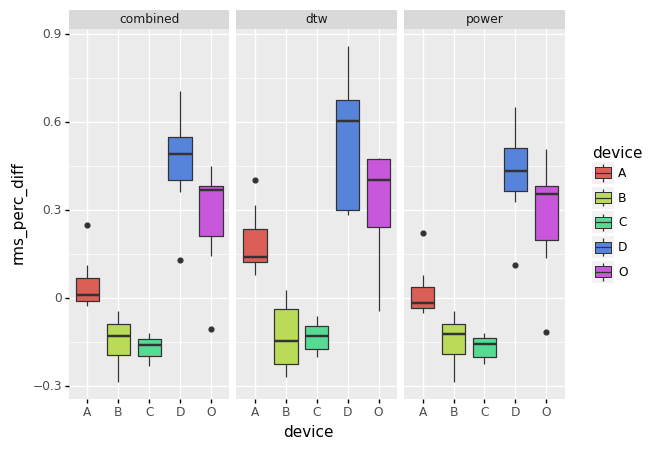

<ggplot: (-9223363272235654684)>

In [83]:
p = ggplot(aes(x='device', y='rms_perc_diff', fill='device'), m1_parsed['scores'])
p + geom_boxplot() + facet_grid('. ~ cost_metric')

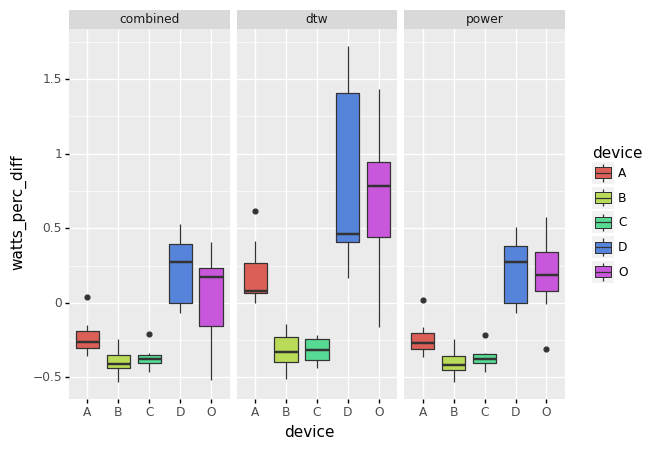

<ggplot: (-9223363279009983274)>

In [38]:
p = ggplot(aes(x='device', y='watts_perc_diff', fill='device'), m2_parsed['scores'])
p + geom_boxplot() + facet_grid('. ~ cost_metric')

## Emperical comparison

In [30]:
def get_melted_result_curves(df_curves):
    df_curves = df_curves.melt(id_vars=['input_id', 'device', 'y_time', 'cost_metric'])
    var_cat = pd.Categorical(df_curves['variable'].values, categories=['y_target', 'y_predict'], ordered=True)
    df_curves['variable'] = var_cat
    return df_curves

In [35]:
m1_mech_curves = get_melted_result_curves(m1_parsed['curves'])
m2_mech_curves = get_melted_result_curves(m2_parsed['curves'])

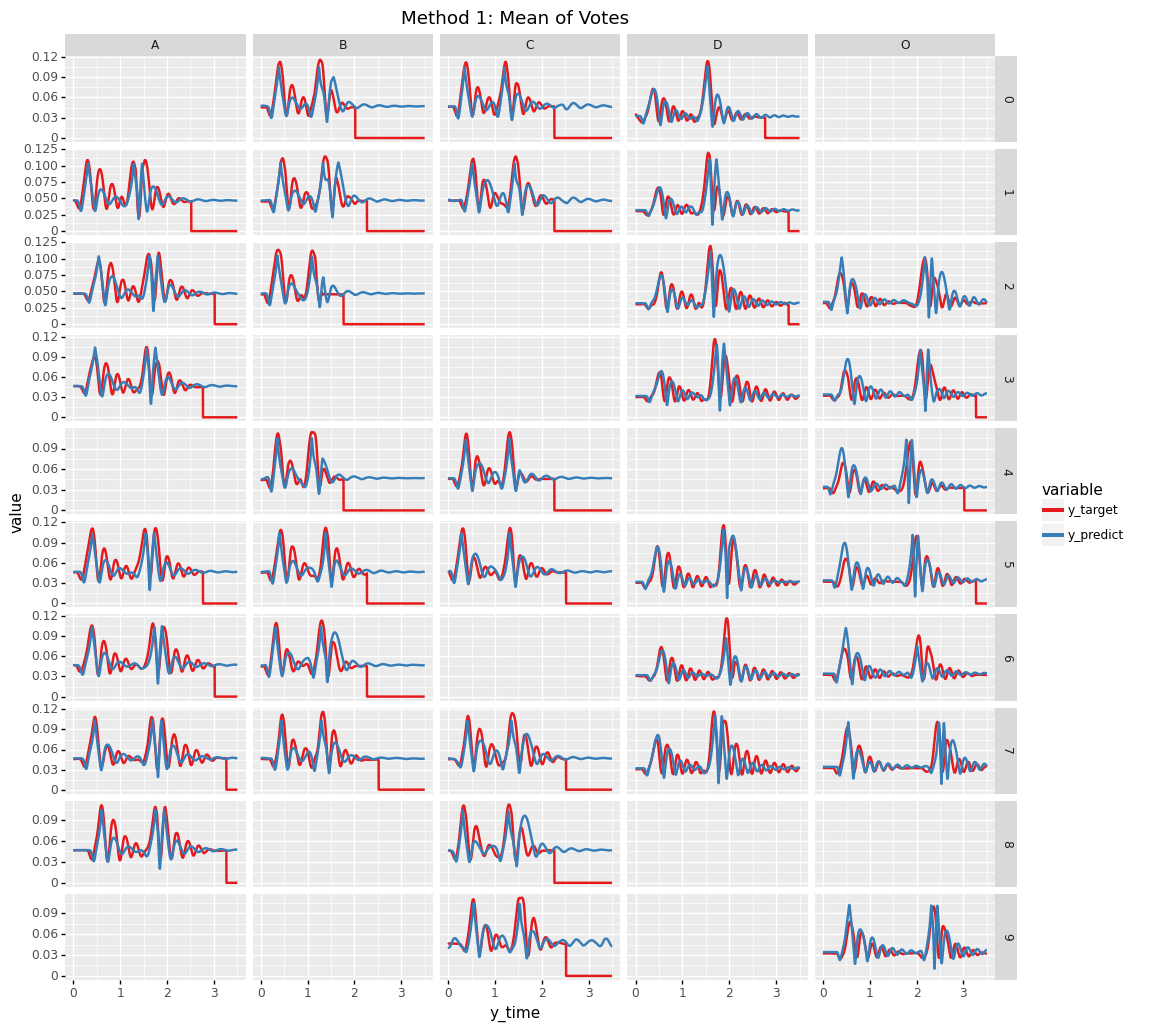

<ggplot: (-9223363278914183827)>

In [36]:
p = ggplot(aes(x='y_time', y='value', color='variable'), m1_mech_curves.query('cost_metric=="power"'))
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ xlim(0, 3.5) \
+ scale_color_brewer('qual', 6) \
+ theme(figure_size=(12, 12)) \
+ ggtitle("Method 1: Mean of Votes")

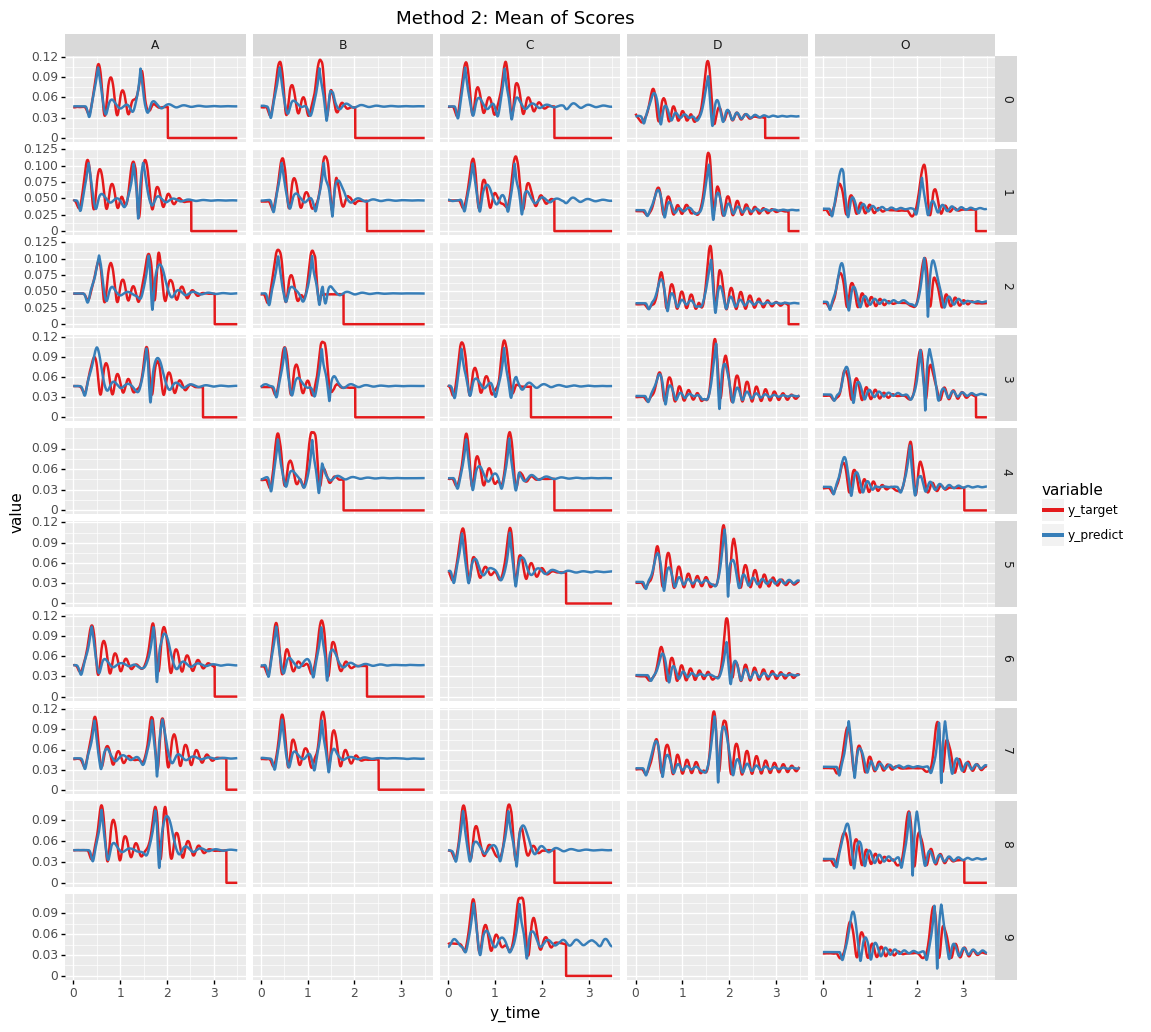

<ggplot: (8757949714864)>

In [37]:
p = ggplot(aes(x='y_time', y='value', color='variable'), m2_mech_curves.query('cost_metric=="combined"'))
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ xlim(0, 3.5) \
+ scale_color_brewer('qual', 6) \
+ theme(figure_size=(12, 12)) \
+ ggtitle("Method 2: Mean of Scores")

Can you subjectively tell which looks better? I think Method 2 _looks_ better.

### Elec

In [99]:
m1_elec_curves = get_melted_result_curves(m1_parsed['curves'], 'elec')
m2_elec_curves = get_melted_result_curves(m2_parsed['curves'], 'elec')

In [100]:
m1_elec_curves.head()

,input_id,device,y_time,cost_metric,variable,value
0,1,A,0.0000,dtw,y_target,0.045993
1,1,A,0.0008,dtw,y_target,0.046073
2,1,A,0.0016,dtw,y_target,0.046150
3,1,A,0.0024,dtw,y_target,0.046222
4,1,A,0.0032,dtw,y_target,0.046291


In [98]:
p = ggplot(aes(x='emf_time', y='value', color='variable'), m1_elec_curves.query('cost_metric=="combined"'))
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ scale_color_brewer('qual', 6) \
+ theme(figure_size=(12, 12)) \
+ ggtitle("Method 1: Mean of Votes")

PlotnineError: "Could not evaluate the 'x' mapping: 'emf_time' (original error: name 'emf_time' is not defined)"

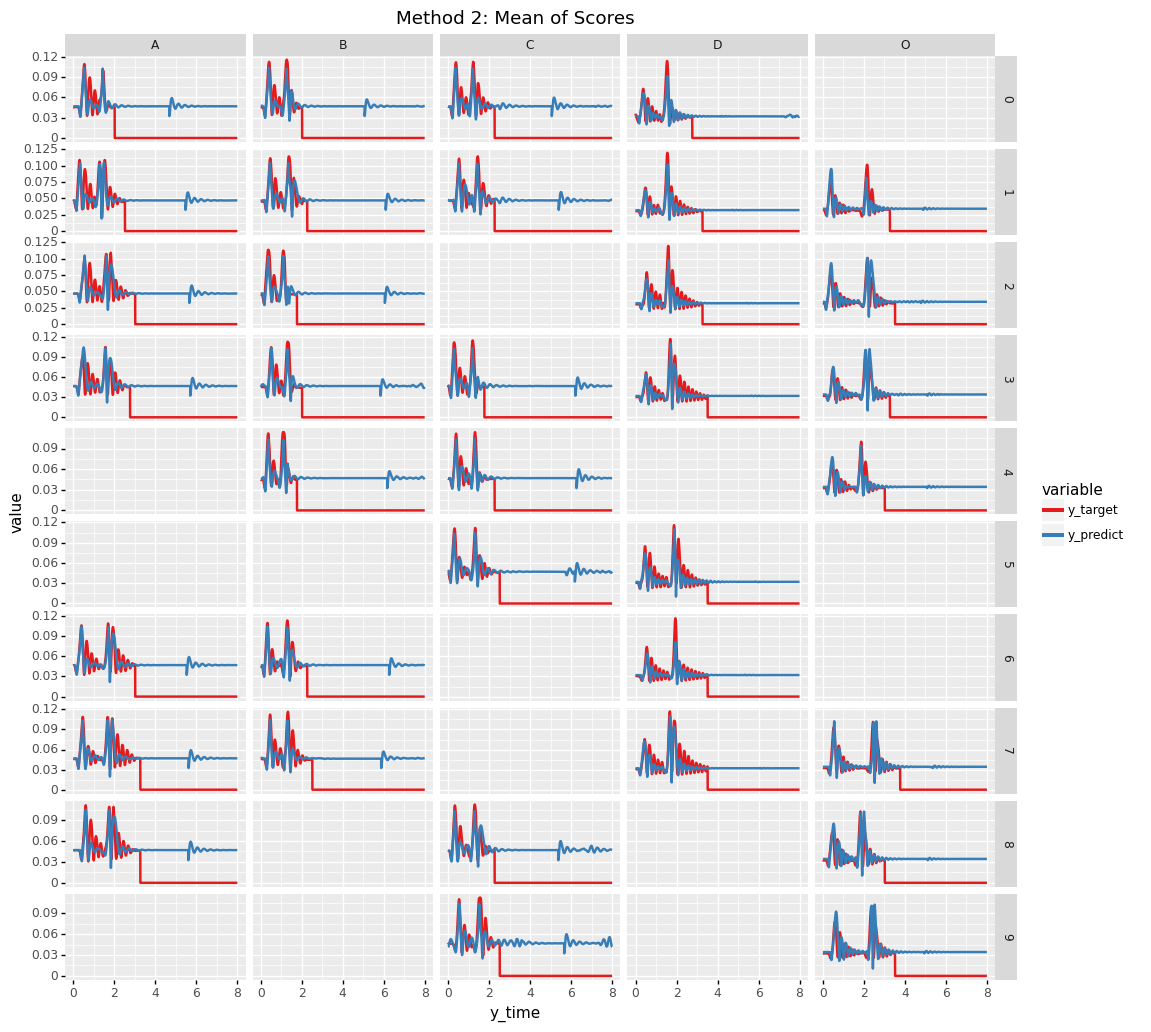

<ggplot: (8764576504121)>

In [95]:
p = ggplot(aes(x='y_time', y='value', color='variable'), m2_elec_curves.query('cost_metric=="combined"'))
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ scale_color_brewer('qual', 6) \
+ theme(figure_size=(12, 12)) \
+ ggtitle("Method 2: Mean of Scores")